# 1. Setup e Imports

In [34]:
# - Local (VS Code): instalar deps con `pip install -r requirements.txt` y correr directo.
# - Colab: esta celda instala solo lo necesario, sin desinstalar nada.

import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip -q install --upgrade --force-reinstall "numpy==1.26.4"
    %pip -q install "pandas>=1.5,<2.3" "matplotlib>=3.7,<3.9" "seaborn>=0.12" "scipy>=1.10,<1.14" "fitter==1.7.1"

# Imports
import os
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fitter import Fitter
from dataclasses import dataclass

# Estilo / reproducibilidad / display
sns.set(style="whitegrid")
np.random.seed(42)
random.seed(42)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

# (Opcional) mostrar versiones en Colab
if IN_COLAB:
    import importlib
    for m in ("numpy","pandas","matplotlib","seaborn","scipy","fitter"):
        mod = importlib.import_module(m)
        print(f"{m:>10}: {getattr(mod,'__version__','?')}")

# 2. Ingesta Dataset externo

In [35]:
# Carpeta de inputs (Colab vs local)
DATA_DIR = Path("/content/inputs") if IN_COLAB else (Path.cwd() / "inputs")
DATA_DIR.mkdir(parents=True, exist_ok=True)

SCENARIO_CSV = DATA_DIR / "blockchain_real_state_data_2021_2022.csv"  # <- cambiar si es otro nombre de archivo

if not SCENARIO_CSV.exists():
    raise FileNotFoundError(
        f"No encuentro el archivo de escenarios: {SCENARIO_CSV}\n"
        f"Colocalo en {DATA_DIR} o cambiá el nombre arriba."
    )

df_scenarios = pd.read_csv(SCENARIO_CSV)
print("✅ Escenarios cargados:", df_scenarios.shape)
print("▶ Ruta:", SCENARIO_CSV)
print("▶ Columnas:", list(df_scenarios.columns))

# Unidad de tiempo de toda la sim
TIME_UNIT = "horas"

✅ Escenarios cargados: (54000, 7)
▶ Ruta: c:\Users\julia\Proyectos\simu-blockchain\inputs\blockchain_real_state_data_2021_2022.csv
▶ Columnas: ['requested_tokenization_delay_min', 'requested_mint_time', 'potential_buyer_arrival_delay_time', 'potential_buyer_buy_time', 'mint_delay_min', 'burn_token_time', 'price_update_time']


# 3. FDPs TS/LLIN desde el dataset

In [36]:
import os, json, pandas as pd
from fitter import Fitter
from scipy import stats

os.makedirs("outputs", exist_ok=True)

# === Config: cuántas filas usar del dataset ===
USE_N_ROWS = 10            # None -> usar todas
USE_RANDOM_SAMPLE = False   # False -> primeras N en orden
RANDOM_SEED = 42

# Subset del dataset
df_use = df_scenarios
if isinstance(USE_N_ROWS, int):
    n = min(USE_N_ROWS, len(df_scenarios))
    df_use = (
        df_scenarios.sample(n=n, random_state=RANDOM_SEED)
        if USE_RANDOM_SAMPLE else
        df_scenarios.head(n)
    )
print(f"[FDPs] Usando {len(df_use)}/{len(df_scenarios)} filas del dataset")

# Tu dataset: TS en minutos, LLIN en horas → convertimos a HORAS
ts_hours   = pd.to_numeric(df_use["mint_delay_min"], errors="coerce").dropna() / 60.0
llin_hours = pd.to_numeric(df_use["potential_buyer_arrival_delay_time"], errors="coerce").dropna()

ts_hours   = ts_hours[ts_hours > 0]
llin_hours = llin_hours[llin_hours > 0]

def fit_best_all(series):
    s = series[series > 0]
    if len(s) < 3: 
        print("⚠️ Muy pocos datos para ajustar:", len(s))
        return {}
    f = Fitter(s)  # prueba TODAS las distribuciones disponibles
    f.fit()
    return f.get_best(method="sumsquare_error")  # {'dist': {params}}

best_ts_dataset   = fit_best_all(ts_hours)
best_llin_dataset = fit_best_all(llin_hours)

# Samplers para la simulación (si hay ajuste)
def _make_sampler(best):
    if not best: return None
    name, params = list(best.items())[0]
    return lambda: float(getattr(stats, name).rvs(size=1, **params)[0])

gen_TS_dataset   = _make_sampler(best_ts_dataset)
gen_LLIN_dataset = _make_sampler(best_llin_dataset)

if callable(gen_TS_dataset):
    print("TS (h) muestras:",   [round(gen_TS_dataset(), 4) for _ in range(5)])
else:
    print("TS (h) sin ajuste (se usará exponencial de fallback).")

if callable(gen_LLIN_dataset):
    print("LLIN (h) muestras:", [round(gen_LLIN_dataset(), 4) for _ in range(5)])
else:
    print("LLIN (h) sin ajuste (se usará exponencial de fallback).")

# Guardar ajustes estimados desde el dataset (en HORAS)
rows_ds = []
def _row_ds(name, best, serie):
    if not best:
        return {"variable": name, "mejor_dist": "sin_ajuste", "params_json": "{}", "n": int(len(serie)), "unidad_tiempo": TIME_UNIT}
    dist, params = list(best.items())[0]
    return {"variable": name, "mejor_dist": dist, "params_json": json.dumps(params), "n": int(len(serie)), "unidad_tiempo": TIME_UNIT}

rows_ds.append(_row_ds("TS",   best_ts_dataset,   ts_hours))
rows_ds.append(_row_ds("LLIN", best_llin_dataset, llin_hours))

pd.DataFrame(rows_ds).to_csv("outputs/ajustes_fdp_dataset.csv", index=False)
with open("outputs/ajustes_fdp_dataset.json","w",encoding="utf-8") as f:
    json.dump(rows_ds, f, ensure_ascii=False, indent=2)
print("✅ Ajustes guardados en outputs/ajustes_fdp_dataset.*")

[FDPs] Usando 10/54000 filas del dataset
TS (h) muestras: [0.3199, 0.5363, 0.4855, 0.4286, 0.2413]
LLIN (h) muestras: [5.3904, 5.3148, 79.9549, 79.9484, 79.9547]
✅ Ajustes guardados en outputs/ajustes_fdp_dataset.*


# 4. Simulación por escenario

In [37]:
@dataclass
class SimResult:
    df_eventos: pd.DataFrame
    metrics: dict
    saldos_compradores: list

def simular_escenario(row: pd.Series, out_dir: Path) -> SimResult:
    out_dir.mkdir(parents=True, exist_ok=True)

    # --------- Parámetros desde el dataset (fallbacks si faltara algo) ----------
    N_EVENTOS   = int(row.get("n_eventos", 1000))
    GAS         = float(row.get("gas_fee_usd", 50.0))
    PARTES_MAX  = int(row.get("partes_de_prop", 1000))

    # medias (en horas) para los tiempos entre eventos
    MEAN_TS   = max(1e-6, float(row.get("mint_delay_min", 20.0)) / 60.0)  # min → h
    MEAN_LLIN = max(1e-6, float(row.get("potential_buyer_arrival_delay_time", 30.0)))  # ya en h
    MEAN_SEC  = max(1e-6, float(row.get("time_to_price_update_days", 3.0)) * 24.0)      # días → h

    # Probabilidades
    P_KYC       = float(row.get("kyc_pass", 0.5))
    P_BURN      = float(row.get("burn_prob", 0.05))
    P_UPDATE    = float(row.get("price_update_prob", 0.10))

    # Valores monetarios base (con un poco de variación para evitar empates rígidos)
    TOKEN_PRICE = float(row.get("token_price_usd", 1000.0))
    BUYER_BUDG  = float(row.get("buyer_budget_usd", 3000.0))
    PRICE_SD    = max(1.0, 0.10 * TOKEN_PRICE)      # ±10%
    BUDG_SD     = max(1.0, 0.15 * BUYER_BUDG)       # ±15%

    # Semilla (si viene definida)
    if "seed" in row and not pd.isna(row["seed"]):
        seed = int(row["seed"])
        np.random.seed(seed)
        random.seed(seed)

    # --------- Estado inicial ----------
    partes_de_prop = PARTES_MAX
    tokens_vend = []                 # tokens disponibles para vender (stock)
    saldo_vend = 5000.0              # saldo inicial del vendedor (puede ajustarse si querés)
    eventos = []
    tiempo = 0.0

    # Métricas
    CTS = 0
    CTF = 0
    tokens_emitidos = 0
    tokens_burneados = 0
    saldos_compradores = []

    # --------- Samplers (todas en horas) ---------
    # Si hay fits desde el dataset, los usamos; si no, exponencial
    gen_TS   = gen_TS_dataset   if 'gen_TS_dataset'   in globals() and callable(gen_TS_dataset)   else (lambda: np.random.exponential(scale=MEAN_TS))
    gen_LLIN = gen_LLIN_dataset if 'gen_LLIN_dataset' in globals() and callable(gen_LLIN_dataset) else (lambda: np.random.exponential(scale=MEAN_LLIN))
    gen_SEC  = lambda: np.random.exponential(scale=MEAN_SEC)

    # Blindaje simple: asegurar que los incrementos sean positivos y finitos
    def _wrap_pos(fn):
        def _inner():
            x = float(fn())
            if not np.isfinite(x) or x <= 0.0:
                return 1e-9  # epsilon positivo (≈ 0 h) para que el tiempo avance
            return x
        return _inner

    gen_TS   = _wrap_pos(gen_TS)
    gen_LLIN = _wrap_pos(gen_LLIN)
    gen_SEC  = _wrap_pos(gen_SEC)

    def gen_token_price():
        return max(10.0, float(np.random.normal(TOKEN_PRICE, PRICE_SD)))

    def gen_buyer_budget():
        return max(0.0, float(np.random.normal(BUYER_BUDG, BUDG_SD)))

    # --------- Simulación principal ----------
    for _ in range(N_EVENTOS):
        r = random.random()

        if r < 0.35:
            # Tokenización solicitada -> mint si hay capacidad y saldo para gas
            tiempo += gen_TS()
            if (tokens_emitidos < partes_de_prop) and (saldo_vend >= GAS):
                CTS += 1
                saldo_vend -= GAS
                token_id = f"T{tokens_emitidos}"
                tokens_vend.append({"id": token_id, "precio": gen_token_price()})
                tokens_emitidos += 1
                eventos.append([tiempo, "mint", token_id, saldo_vend, None])

        elif r < 0.7:
            # Llegada interesado y posible compra
            tiempo += gen_LLIN()
            if random.random() < P_KYC:
                saldo_comprador = gen_buyer_budget()
                if tokens_vend:
                    token = random.choice(tokens_vend)
                    precio = token["precio"]
                    if saldo_comprador >= precio:
                        saldo_comprador -= precio
                        saldo_vend += precio
                        tokens_vend.remove(token)
                        saldos_compradores.append(saldo_comprador)
                        eventos.append([tiempo, "compra_exitosa", token["id"], saldo_vend, saldo_comprador])
                    else:
                        CTF += 1
                        eventos.append([tiempo, "compra_fallida_fondos", token["id"], saldo_vend, saldo_comprador])
                else:
                    CTF += 1
                    eventos.append([tiempo, "compra_fallida_sin_tokens", None, saldo_vend, saldo_comprador])

        else:
            # Secundarios: burn o actualización de precio
            tiempo += gen_SEC()
            if tokens_vend:
                token = random.choice(tokens_vend)
                rr = random.random()
                if rr < P_BURN:
                    tokens_vend.remove(token)
                    tokens_burneados += 1
                    eventos.append([tiempo, "burn_token", token["id"], saldo_vend, None])
                elif rr < (P_BURN + P_UPDATE):
                    nuevo_precio = gen_token_price()
                    token["precio"] = nuevo_precio
                    eventos.append([tiempo, "actualizacion_precio", token["id"], saldo_vend, nuevo_precio])
                # si no cae ni en burn ni en update, ese sub-evento no hace nada

    # --------- DataFrame de eventos ----------
    df_eventos = pd.DataFrame(
        eventos, columns=["tiempo", "evento", "token", "saldo_vendedor", "extra"]
    ).sort_values("tiempo", ignore_index=True)
    df_eventos["tiempo"] = pd.to_numeric(df_eventos["tiempo"], errors="coerce")

    # Chequeos básicos
    assert saldo_vend >= 0, "Saldo del vendedor no puede ser negativo"
    current_unsold = len(tokens_vend)
    assert tokens_emitidos >= tokens_burneados + current_unsold, \
        "Inconsistencia de supply (emitidos < burn + stock)"

    # --------- Métricas finales ----------
    PTB_final_pct = (tokens_burneados / tokens_emitidos * 100.0) if tokens_emitidos > 0 else 0.0
    PSC_final = float(np.mean(saldos_compradores)) if len(saldos_compradores) > 0 else 0.0

    metrics = {
        "CTS": int(CTS),
        "PTB_%": float(PTB_final_pct),
        "PSC": float(PSC_final),
        "CTF": int(CTF),
        "emitidos": int(tokens_emitidos),
        "burneados": int(tokens_burneados),
        "tiempo_min": float(df_eventos["tiempo"].min()) if len(df_eventos) else 0.0,
        "tiempo_max": float(df_eventos["tiempo"].max()) if len(df_eventos) else 0.0,
        "unidad_tiempo": TIME_UNIT,
    }

    # Guardar CSVs del escenario
    df_eventos.to_csv(out_dir / "eventos.csv", index=False)
    pd.DataFrame([metrics]).to_csv(out_dir / "metricas.csv", index=False)

    return SimResult(df_eventos=df_eventos, metrics=metrics, saldos_compradores=saldos_compradores)

# 5. Driver

In [38]:
from pathlib import Path

BASE_OUT = Path("outputs") / "scenarios"
BASE_OUT.mkdir(parents=True, exist_ok=True)

# Elegí cómo correr:
RUN_ALL_SCENARIOS = True          # ← True para correr en batch
SCENARIO_NAME     = None           # ← filtrar por nombre exacto (columna 'scenario')
SCENARIO_IDX      = 0              # ← si no hay nombre, usar el índice de fila

# NUEVO: control de cantidad en batch
N_SCENARIOS          = 10          # None → usar todos. 
BATCH_RANDOM_SAMPLE  = False       # True → muestra aleatoria; False → primeras N
BATCH_RANDOM_SEED    = 42          # semilla para reproducibilidad de la muestra

todos_metrics = []

def _nombre_carpeta(row, i):
    name = str(row.get("scenario", f"scenario_{i:02d}")).strip()
    return name if name else f"scenario_{i:02d}"

if RUN_ALL_SCENARIOS:
    # Elegir subconjunto a iterar
    if isinstance(N_SCENARIOS, int):
        n = min(N_SCENARIOS, len(df_scenarios))
        df_iter = (
            df_scenarios.sample(n=n, random_state=BATCH_RANDOM_SEED)
            if BATCH_RANDOM_SAMPLE else
            df_scenarios.head(n)
        )
        modo = "muestra aleatoria" if BATCH_RANDOM_SAMPLE else "primeras N"
    else:
        df_iter = df_scenarios
        modo = "todos"

    df_iter = df_iter.reset_index(drop=True)
    total = len(df_iter)
    print(f"\n▶ Batch: corriendo {total} escenario(s) ({modo})")

    for i, row in df_iter.iterrows():
        name = _nombre_carpeta(row, i)
        out_dir = BASE_OUT / name
        print(f"\n=== Escenario {i} — {name} ===")
        res = simular_escenario(row, out_dir)

        # Tokens en circulación (por escenario)
        df = res.df_eventos.copy()
        df["evento"] = df["evento"].astype(str).str.lower()
        delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)
        tok = pd.DataFrame({"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}) \
                .dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)
        tok.to_csv(out_dir / "tokens_circulacion.csv", index=False)

        m = res.metrics.copy()
        m["scenario"] = name
        todos_metrics.append(m)

    # Resumen general
    df_metrics = pd.DataFrame(todos_metrics)
    df_metrics.to_csv(BASE_OUT / "resumen_metricas_todos.csv", index=False)
    print("\n✅ Resumen general guardado en:", BASE_OUT / "resumen_metricas_todos.csv")

else:
    # Correr solo un escenario (por nombre o índice)
    if SCENARIO_NAME is not None:
        mask = (df_scenarios["scenario"].astype(str).str.strip() == str(SCENARIO_NAME).strip())
        assert mask.any(), f"No encontré scenario == {SCENARIO_NAME!r}"
        row = df_scenarios[mask].iloc[0]
        idx = int(row.name)
    else:
        idx = int(SCENARIO_IDX)
        row = df_scenarios.iloc[idx]

    name = _nombre_carpeta(row, idx)
    out_dir = BASE_OUT / name
    print(f"\n=== Ejecutando escenario único — {name} ===")
    res = simular_escenario(row, out_dir)

    # Dejamos variables globales para que TUS celdas existentes las usen
    df_eventos = res.df_eventos.copy()
    CTS = res.metrics["CTS"]
    CTF = res.metrics["CTF"]
    tokens_emitidos = res.metrics["emitidos"]
    tokens_burneados = res.metrics["burneados"]
    saldos_compradores = list(res.saldos_compradores)

    print("📁 Salida del escenario:", out_dir.resolve())


▶ Batch: corriendo 10 escenario(s) (primeras N)

=== Escenario 0 — scenario_00 ===

=== Escenario 1 — scenario_01 ===

=== Escenario 2 — scenario_02 ===

=== Escenario 3 — scenario_03 ===

=== Escenario 4 — scenario_04 ===

=== Escenario 5 — scenario_05 ===

=== Escenario 6 — scenario_06 ===

=== Escenario 7 — scenario_07 ===

=== Escenario 8 — scenario_08 ===

=== Escenario 9 — scenario_09 ===

✅ Resumen general guardado en: outputs\scenarios\resumen_metricas_todos.csv


# 6. Unificar eventos de todos los escenarios

In [39]:
if globals().get("RUN_ALL_SCENARIOS", False):
    from pathlib import Path
    import pandas as pd

    BASE_OUT = Path("outputs/scenarios")
    assert BASE_OUT.exists(), "No existe outputs/scenarios. Corré antes el Driver."

    scen_dirs = sorted([p for p in BASE_OUT.iterdir() if p.is_dir() and p.name != "_global"])
    assert scen_dirs, f"No hay escenarios en {BASE_OUT}. Corré antes el Driver con RUN_ALL_SCENARIOS=True."

    rows = []
    total = len(scen_dirs)
    for i, d in enumerate(scen_dirs, start=1):
        ev_path = d / "eventos.csv"
        if not ev_path.exists():
            print(f"⚠️ Salto {d.name}: no tiene eventos.csv")
            continue
        print(f"[{i}/{total}] Unificando: {d.name}")
        df = pd.read_csv(ev_path)
        df["scenario"] = d.name
        rows.append(df)

    if not rows:
        raise RuntimeError("No encontré eventos.csv en ninguna carpeta de escenario.")

    df_eventos_all = pd.concat(rows, ignore_index=True)
    if "tiempo" in df_eventos_all.columns:
        df_eventos_all["tiempo"] = pd.to_numeric(df_eventos_all["tiempo"], errors="coerce")

    GLOBAL_DIR = BASE_OUT / "_global"
    GLOBAL_DIR.mkdir(parents=True, exist_ok=True)
    csv_out = GLOBAL_DIR / "eventos_all.csv"
    df_eventos_all.to_csv(csv_out, index=False)
    try:
        df_eventos_all.to_parquet(GLOBAL_DIR / "eventos_all.parquet", index=False)
    except Exception:
        pass

    print(f"✅ Unificado {len(rows)} escenarios → {len(df_eventos_all):,} filas")
    print("📁 Guardado:", csv_out)

    # Para usar el EDA use el unificado:
    df_eventos = df_eventos_all.copy()

[1/10] Unificando: scenario_00
[2/10] Unificando: scenario_01
[3/10] Unificando: scenario_02
[4/10] Unificando: scenario_03
[5/10] Unificando: scenario_04
[6/10] Unificando: scenario_05
[7/10] Unificando: scenario_06
[8/10] Unificando: scenario_07
[9/10] Unificando: scenario_08
[10/10] Unificando: scenario_09
✅ Unificado 10 escenarios → 5,733 filas
📁 Guardado: outputs\scenarios\_global\eventos_all.csv


# 7. Análisis Exploratorio de Datos

In [40]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd

# ---- Config rápida ----
DO_PLOTS_BATCH  = False   # <- en batch: sin gráficos para ir más rápido
DO_PLOTS_SINGLE = True    # <- en escenario único: sí gráficos 
HEAD_N          = 5       # filas a mostrar
BASE_OUT        = Path("outputs/scenarios")
TIME_UNIT       = globals().get("TIME_UNIT", "horas")

def _eda_sencilla(df_eventos: pd.DataFrame, time_unit="días",
                  save_dir: Path | None = None, do_plots: bool = False,
                  head_n: int = 5):
    """Devuelve un dict-resumen. Gráficos opcionales (do_plots)."""
    resumen = {
        "n_filas":    int(df_eventos.shape[0]),
        "n_cols":     int(df_eventos.shape[1]),
        "t_min":      float(df_eventos["tiempo"].min()) if "tiempo" in df_eventos.columns and len(df_eventos) else np.nan,
        "t_max":      float(df_eventos["tiempo"].max()) if "tiempo" in df_eventos.columns and len(df_eventos) else np.nan,
        "duracion":   np.nan,
        "mint":       int((df_eventos["evento"].str.lower()=="mint").sum()) if "evento" in df_eventos.columns else 0,
        "compra_ok":  int((df_eventos["evento"].str.lower()=="compra_exitosa").sum()) if "evento" in df_eventos.columns else 0,
        "compra_fail_fondos": int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum()) if "evento" in df_eventos.columns else 0,
        "compra_fail_sintok": int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum()) if "evento" in df_eventos.columns else 0,
        "burn":       int((df_eventos["evento"].str.lower()=="burn_token").sum()) if "evento" in df_eventos.columns else 0,
    }
    if not np.isnan(resumen["t_min"]) and not np.isnan(resumen["t_max"]):
        resumen["duracion"] = float(resumen["t_max"] - resumen["t_min"])

    # Prints livianos
    print("▶ Forma:", df_eventos.shape, " | cols:", list(df_eventos.columns))
    if "tiempo" in df_eventos.columns:
        print(f"▶ Tiempo: min={resumen['t_min']:.2f}, max={resumen['t_max']:.2f} {time_unit}, duración={resumen['duracion']:.2f} {time_unit}")
    print("▶ Top filas:")
    print(df_eventos.head(head_n).to_string(index=False))

    # Gráficos opcionales (desactivado en batch)
    if do_plots:
        import matplotlib.pyplot as plt, seaborn as sns
        sns.set(style="whitegrid")

        # Frecuencia de eventos
        evt_counts = df_eventos["evento"].value_counts()
        if len(evt_counts):
            df_evt = evt_counts.rename_axis('evento').reset_index(name='frecuencia')
            plt.figure(figsize=(8,4))
            sns.barplot(data=df_evt, x="evento", y="frecuencia", hue="evento",
                        palette="viridis", dodge=False, legend=False)
            plt.xticks(rotation=20, ha="right")
            plt.title("Frecuencia de eventos")
            plt.tight_layout()
            if save_dir:
                save_dir.mkdir(parents=True, exist_ok=True)
                plt.savefig(save_dir / "freq_eventos.png", dpi=150)
            plt.show()

        # Intervalos entre eventos
        if "tiempo" in df_eventos.columns:
            intervalos = df_eventos["tiempo"].diff().dropna()
            if len(intervalos):
                plt.figure(figsize=(8,4))
                sns.histplot(intervalos, bins=50, kde=True)
                plt.xlabel(f"Δ tiempo entre eventos ({time_unit})")
                plt.title("Distribución de intervalos entre eventos")
                plt.tight_layout()
                if save_dir:
                    plt.savefig(save_dir / "intervalos_eventos.png", dpi=150)
                plt.show()

    return resumen

# ---- Modo batch vs escenario único ----
ran_batch = bool(globals().get("RUN_ALL_SCENARIOS", False))

if ran_batch:
    scen_dirs = sorted([p for p in BASE_OUT.iterdir() if p.is_dir() and p.name != "_global"])
    assert scen_dirs, f"No hay escenarios en {BASE_OUT}. Corré antes el Driver con RUN_ALL_SCENARIOS=True."

    summaries = []
    total = len(scen_dirs)
    for i, d in enumerate(scen_dirs, 1):
        ev_path = d / "eventos.csv"
        if not ev_path.exists():
            print(f"[{i}/{total}] ⚠️ Salto {d.name}: no tiene eventos.csv")
            continue

        print(f"[{i}/{total}] EDA escenario: {d.name}")
        df_e = pd.read_csv(ev_path)
        s = _eda_sencilla(df_e, time_unit=TIME_UNIT, save_dir=d / "eda",
                          do_plots=DO_PLOTS_BATCH, head_n=HEAD_N)
        s["scenario"] = d.name
        summaries.append(s)

    # Resumen global liviano
    if summaries:
        gdir = BASE_OUT / "_global"
        gdir.mkdir(parents=True, exist_ok=True)
        df_sum = pd.DataFrame(summaries)
        df_sum.to_csv(gdir / "eda_batch_summary.csv", index=False)
        print("✅ Guardado resumen global:", (gdir / "eda_batch_summary.csv").resolve())
    else:
        print("ℹ️ No hubo escenarios válidos para resumir.")

else:
    # Escenario único: usa df_eventos ya en memoria
    assert 'df_eventos' in globals(), "df_eventos no está definido; corré antes el Driver en modo escenario único."
    print("[1/1] EDA escenario único")
    _ = _eda_sencilla(df_eventos, time_unit=TIME_UNIT, save_dir=Path("outputs/eda"),
                      do_plots=DO_PLOTS_SINGLE, head_n=HEAD_N)

[1/10] EDA escenario: scenario_00
▶ Forma: (554, 5)  | cols: ['tiempo', 'evento', 'token', 'saldo_vendedor', 'extra']
▶ Tiempo: min=5.31, max=39101.05 horas, duración=39095.74 horas
▶ Top filas:
   tiempo                    evento token  saldo_vendedor      extra
 5.314727 compra_fallida_sin_tokens   NaN          5000.0 2738.60484
 5.562910                      mint    T0          4950.0        NaN
 5.852356                      mint    T1          4900.0        NaN
31.071152                      mint    T2          4850.0        NaN
31.308775                      mint    T3          4800.0        NaN
[2/10] EDA escenario: scenario_01
▶ Forma: (570, 5)  | cols: ['tiempo', 'evento', 'token', 'saldo_vendedor', 'extra']
▶ Tiempo: min=70.04, max=39567.45 horas, duración=39497.41 horas
▶ Top filas:
    tiempo         evento token  saldo_vendedor       extra
 70.040166           mint    T0     4950.000000         NaN
458.690178           mint    T1     4900.000000         NaN
563.677027 comp

# 8. Variables de Resultados


=== RESULTADOS ===
CTS (Cantidad total de tokenizaciones solicitadas): 354
PTB (Porcentaje de tokens burneados): 3.39% (burn=12, emitidos=354)
PSC (Promedio de saldo compradores): 2104.70
CTF (Cantidad de transferencias fallidas): 1


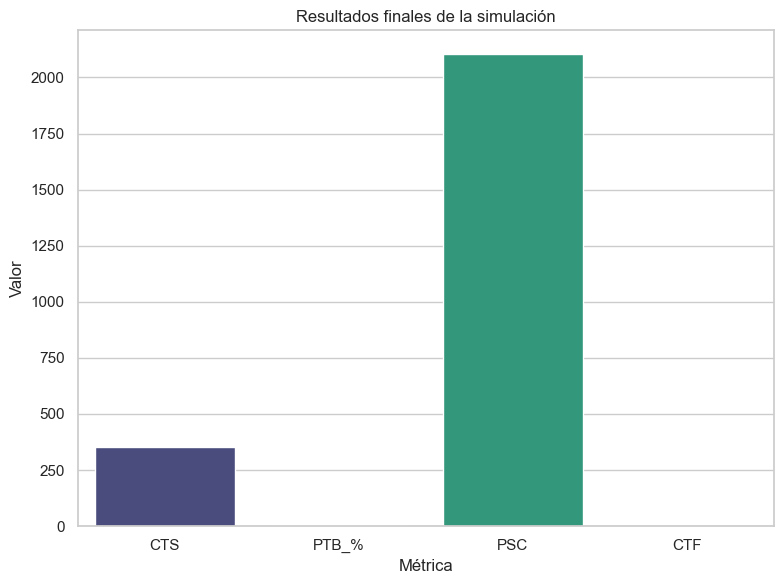

In [41]:
import os, numpy as np, pandas as pd
os.makedirs("outputs", exist_ok=True)

# Helper: derivar métricas desde df_eventos si no hay globals
def _metrics_from_df(df):
    d = df.copy()
    d["evento"] = d["evento"].astype(str).str.lower()

    cts = int((d["evento"] == "mint").sum())
    ctf = int(d["evento"].isin(["compra_fallida_fondos", "compra_fallida_sin_tokens"]).sum())
    emitidos = cts
    burneados = int((d["evento"] == "burn_token").sum())

    # PSC: promedio del 'extra' en compras exitosas (saldo remanente del comprador)
    comp = pd.to_numeric(d.loc[d["evento"] == "compra_exitosa", "extra"], errors="coerce").dropna()
    psc = float(comp.mean()) if len(comp) > 0 else 0.0

    return cts, ctf, emitidos, burneados, psc

# Caso A: escenario único (las globals existen)
if all(k in globals() for k in ("CTS", "CTF", "tokens_emitidos", "tokens_burneados")):
    CTS_final = int(CTS)
    CTF_final = int(CTF)
    tokens_emitidos_final = int(tokens_emitidos)
    tokens_burneados_final = int(tokens_burneados)

    # PSC: si no hay saldos_compradores global, derivar de df_eventos
    if "saldos_compradores" in globals() and len(saldos_compradores) > 0:
        PSC_final = float(np.mean(saldos_compradores))
    else:
        _, _, _, _, PSC_final = _metrics_from_df(df_eventos)

# Caso B: batch/unificado (no hay globals): derivar TODO desde df_eventos
else:
    CTS_final, CTF_final, tokens_emitidos_final, tokens_burneados_final, PSC_final = _metrics_from_df(df_eventos)

PTB_final_pct = (tokens_burneados_final / tokens_emitidos_final * 100.0) if tokens_emitidos_final > 0 else 0.0

# Tabla de métricas y export
res_df = pd.DataFrame([
    {"metrica": "CTS",   "valor": CTS_final},
    {"metrica": "PTB_%", "valor": PTB_final_pct},
    {"metrica": "PSC",   "valor": PSC_final},
    {"metrica": "CTF",   "valor": CTF_final},
])
res_df.to_csv("outputs/metricas.csv", index=False)

# Exportar conteo de eventos
evt_counts = df_eventos["evento"].value_counts().rename_axis("evento").reset_index(name="frecuencia")
evt_counts.to_csv("outputs/conteo_eventos.csv", index=False)

# Prints formateados
print("\n=== RESULTADOS ===")
print(f"CTS (Cantidad total de tokenizaciones solicitadas): {CTS_final}")
print(f"PTB (Porcentaje de tokens burneados): {PTB_final_pct:.2f}% "
      f"(burn={tokens_burneados_final}, emitidos={tokens_emitidos_final})")
print(f"PSC (Promedio de saldo compradores): {PSC_final:.2f}")
print(f"CTF (Cantidad de transferencias fallidas): {CTF_final}")

# Gráfico (una sola vez)
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(
    data=res_df,
    x="metrica", y="valor",
    hue="metrica", palette="viridis",
    dodge=False, legend=False
)
plt.xlabel("Métrica"); plt.ylabel("Valor"); plt.title("Resultados finales de la simulación")
plt.tight_layout(); plt.savefig("outputs/metricas_bar.png", dpi=150); plt.show()

# 9. Visualizaciones de Resultados

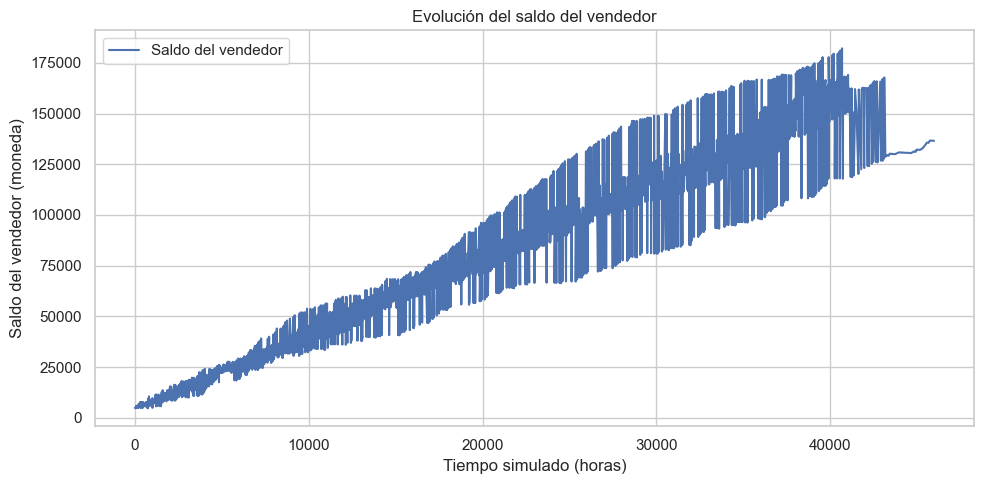

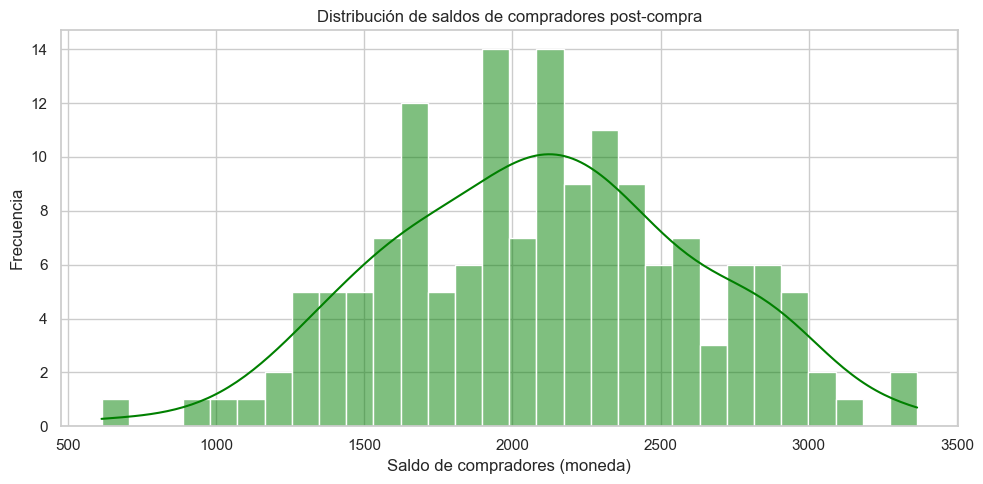

In [42]:
import os
os.makedirs("outputs", exist_ok=True)

# 9.1 Evolución del saldo del vendedor
plt.figure(figsize=(10,5))
sns.lineplot(data=df_eventos, x="tiempo", y="saldo_vendedor", label="Saldo del vendedor")
plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
plt.ylabel("Saldo del vendedor (moneda)")
plt.title("Evolución del saldo del vendedor")
plt.tight_layout()
plt.savefig("outputs/saldo_vendedor_tiempo.png", dpi=150)
plt.show()

# 9.2 Distribución de saldos de compradores (solo si hubo compras)
if len(saldos_compradores) > 0:
    plt.figure(figsize=(10,5))
    sns.histplot(saldos_compradores, bins=30, kde=True, color="green")
    plt.xlabel("Saldo de compradores (moneda)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de saldos de compradores post-compra")
    plt.tight_layout()
    plt.savefig("outputs/dist_saldos_compradores.png", dpi=150)
    plt.show()
else:
    print("No hay compras exitosas, no se grafica la distribución de saldos de compradores.")

# 10. Tokens en circulación vs tiempo

⏱ Tiempo simulado: 0.37 → 45968.65 horas
📏 Duración total: 45968.27 horas
📊 Registros: 5733
🔢 Tokens en circulación (final): 3023
📁 CSV: outputs/tokens_circulacion.csv
📁 Resumen guardado en: outputs/resumen_tiempo.csv


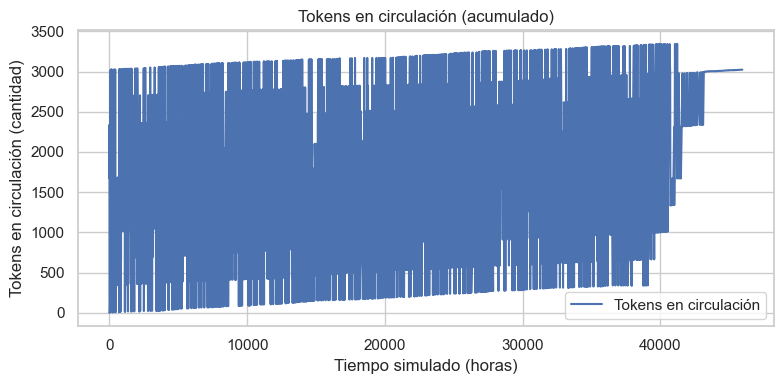

🖼️ PNG: outputs/tokens_circulacion.png


In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tokens_y_resumen(
    df_eventos: pd.DataFrame,
    csv_path: str = "outputs/tokens_circulacion.csv",
    png_path: str = "outputs/tokens_circulacion.png",
    resumen_path: str = "outputs/resumen_tiempo.csv",
    overwrite_csv: bool = True,
    make_plot: bool = True,
):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # Validaciones mínimas
    if "evento" not in df_eventos.columns or "tiempo" not in df_eventos.columns:
        raise ValueError("df_eventos debe contener las columnas 'evento' y 'tiempo'.")

    # Normalización básica
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")

    # Solo 'mint' (+1) y 'burn_token' (-1) cambian el supply
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)

    tok = pd.DataFrame(
        {"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}
    ).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

    # Exportar CSV idempotente
    if overwrite_csv or not os.path.exists(csv_path):
        tok.to_csv(csv_path, index=False)

    # Resumen numérico
    if len(tok) > 0:
        t_min = float(tok["tiempo"].min())
        t_max = float(tok["tiempo"].max())
        duracion = t_max - t_min
        n_reg = int(len(tok))
        final_supply = int(tok["tokens_circulacion"].iloc[-1])
    else:
        t_min = t_max = duracion = 0.0
        n_reg = final_supply = 0

    print(f"⏱ Tiempo simulado: {t_min:.2f} → {t_max:.2f} {TIME_UNIT}")
    print(f"📏 Duración total: {duracion:.2f} {TIME_UNIT}")
    print(f"📊 Registros: {n_reg}")
    print(f"🔢 Tokens en circulación (final): {final_supply}")
    print(f"📁 CSV: {csv_path}")

    # Exportar resumen a CSV
    resumen_df = pd.DataFrame([{
        "tiempo_min": t_min,
        "tiempo_max": t_max,
        "duracion": duracion,
        "n_registros": n_reg,
        "tokens_final": final_supply,
        "unidad_tiempo": TIME_UNIT,
    }])
    resumen_df.to_csv(resumen_path, index=False)
    print(f"📁 Resumen guardado en: {resumen_path}")

    # Gráfico opcional
    if make_plot and len(tok) > 0:
        plt.figure(figsize=(8,4))
        plt.plot(tok["tiempo"], tok["tokens_circulacion"], label="Tokens en circulación")
        plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
        plt.ylabel("Tokens en circulación (cantidad)")
        plt.title("Tokens en circulación (acumulado)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(png_path, dpi=150)
        plt.show()
        print(f"🖼️ PNG: {png_path}")

    return tok, resumen_df

tok, resumen_tiempo = generar_tokens_y_resumen(
    df_eventos,
    csv_path="outputs/tokens_circulacion.csv",
    png_path="outputs/tokens_circulacion.png",
    resumen_path="outputs/resumen_tiempo.csv",
    overwrite_csv=True,    # False para NO reescribir el CSV existente
    make_plot=True         # False para no generar el PNG
)

# 11. Conclusiones

In [44]:
import os
import numpy as np
import pandas as pd
from textwrap import dedent

os.makedirs("outputs", exist_ok=True)

# ---- 1) Insumos: df_eventos, métricas, supply ----
# Métricas básicas (si no existen, las reconstruye)
CTS_val = int(CTS) if "CTS" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_emitidos_val = int(tokens_emitidos) if "tokens_emitidos" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_burneados_val = int(tokens_burneados) if "tokens_burneados" in locals() else int((df_eventos["evento"].str.lower()=="burn_token").sum())

if "PTB_final_pct" in locals():
    PTB_pct = float(PTB_final_pct)
else:
    PTB_pct = (tokens_burneados_val / tokens_emitidos_val * 100.0) if tokens_emitidos_val>0 else 0.0

PSC_val = float(PSC_final) if "PSC_final" in locals() else float(np.nan)
CTF_val = int(CTF) if "CTF" in locals() else int((df_eventos["evento"].str.contains("compra_fallida", case=False, na=False)).sum())

# Supply vs tiempo
tok_path = "outputs/tokens_circulacion.csv"
if os.path.exists(tok_path):
    tok = pd.read_csv(tok_path)
else:
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)
    tok = pd.DataFrame({"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

t_min = float(tok["tiempo"].min()) if len(tok)>0 else 0.0
t_max = float(tok["tiempo"].max()) if len(tok)>0 else 0.0
duracion = t_max - t_min
final_supply = int(tok["tokens_circulacion"].iloc[-1]) if len(tok)>0 else 0

# Tendencia del supply al final (slope en el último 30%)
if len(tok) >= 5:
    tail = tok.tail(max(5, int(len(tok)*0.3)))
    try:
        m, b = np.polyfit(tail["tiempo"], tail["tokens_circulacion"], 1)
    except Exception:
        m = 0.0
    if m > 0.02: tendencia_supply = "creciente"
    elif m < -0.02: tendencia_supply = "decreciente"
    else: tendencia_supply = "estable"
else:
    tendencia_supply = "indefinida"

# ---- 2) Tasas, fallas y stock ----
compras_mask = df_eventos["evento"].str.contains("compra", case=False, na=False)
total_compras = int(compras_mask.sum())
exitosas = int((df_eventos["evento"].str.lower()=="compra_exitosa").sum())
tasa_exito = (exitosas/total_compras*100.0) if total_compras>0 else np.nan

fall_fondos = int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum())
fall_sintok = int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum())

# Stock sin vender al cierre: mint - burn - vendidas
mint_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "token"].dropna())
burn_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="burn_token", "token"].dropna())
sold_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="compra_exitosa", "token"].dropna())
stock_sin_vender = max(0, len(mint_ids - burn_ids - sold_ids))

# ---- 3) Intervalos TS / LLIN y mejor FDP si existiera ----
ts_series = tiempos_ts if 'tiempos_ts' in globals() else (
    df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "tiempo"]
    .diff().dropna()
)
llin_series = tiempos_llin if 'tiempos_llin' in globals() else (
    df_eventos.loc[df_eventos["evento"].str.contains("compra", case=False, na=False), "tiempo"]
    .diff().dropna()
)

ts_mean   = float(ts_series.mean()) if len(ts_series)>0 else np.nan
llin_mean = float(llin_series.mean()) if len(llin_series)>0 else np.nan

def _best_name_from_dataset(best_dict):
    try:
        return list(best_dict.keys())[0] if best_dict else None
    except Exception:
        return None

# 1) Intentar con los fits del DATASET (bloque 2.1)
best_ts_name = _best_name_from_dataset(best_ts_dataset) if 'best_ts_dataset' in globals() else None
best_llin_name = _best_name_from_dataset(best_llin_dataset) if 'best_llin_dataset' in globals() else None

# 2) Si no están en memoria, leer de outputs/ajustes_fdp_dataset.csv
if (best_ts_name is None or best_llin_name is None) and os.path.exists("outputs/ajustes_fdp_dataset.csv"):
    try:
        aj = pd.read_csv("outputs/ajustes_fdp_dataset.csv")
        if best_ts_name is None:
            row = aj.loc[aj["variable"] == "TS"]
            if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
        if best_llin_name is None:
            row = aj.loc[aj["variable"] == "LLIN"]
            if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
    except Exception:
        pass

# Fallback final: leer archivos si existen
if best_ts_name is None or best_llin_name is None:
    for path in ["outputs/ajustes_fdp_sim.csv", "outputs/ajustes_fdp.csv"]:
        if os.path.exists(path):
            try:
                aj = pd.read_csv(path)
                if best_ts_name is None:
                    row = aj.loc[aj["variable"].str.contains("TS", na=False)]
                    if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
                if best_llin_name is None:
                    row = aj.loc[aj["variable"].str.contains("LLIN", na=False)]
                    if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
            except: 
                pass

# ---- 4) Recomendaciones automáticas (simples) ----
recs = []

# Oferta vs demanda
if not np.isnan(ts_mean) and not np.isnan(llin_mean):
    if ts_mean > llin_mean:
        recs.append("La tokenización (TS) es más lenta que las llegadas (LLIN): podés **acelerar TS** (mayor emisión) o **aumentar `partes_de_prop`** para reducir faltantes.")
    else:
        recs.append("La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.")

# Motivo principal de fallas
if fall_sintok > fall_fondos:
    recs.append("Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.")
elif fall_fondos > fall_sintok:
    recs.append("Las fallas por **fondos insuficientes** dominan: considerá **bajar `VALOR_TOKEN_MEDIA`** o modificar la distribución de saldos de compradores.")
else:
    if total_compras>0:
        recs.append("Las fallas se reparten parejo entre fondos y disponibilidad; podés actuar en ambos frentes: oferta y pricing.")

# PTB alto
if PTB_pct >= 20:
    recs.append("**PTB** elevado: revisar criterios de `burn_token` (P_BURN) para no erosionar el supply.")
elif PTB_pct <= 1 and tendencia_supply=="creciente":
    recs.append("**PTB** muy bajo y supply creciente: OK si es deseado; de lo contrario, introducir `burn` para controlar el circulante.")

# ---- 5) Componer conclusiones (Markdown) ----
ts_line   = f"- Tokenización (TS): media ≈ {ts_mean:.2f} {TIME_UNIT}" if not np.isnan(ts_mean) else "- Tokenización (TS): sin datos suficientes"
ts_line  += f"{' — mejor FDP: '+best_ts_name if best_ts_name else ''}"

llin_line = f"- Llegadas (LLIN): media ≈ {llin_mean:.2f} {TIME_UNIT}" if not np.isnan(llin_mean) else "- Llegadas (LLIN): sin datos suficientes"
llin_line+= f"{' — mejor FDP: '+best_llin_name if best_llin_name else ''}"

tasa_line = f"- Compras: {exitosas}/{total_compras} exitosas (**{tasa_exito:.1f}%**)" if total_compras>0 else "- Compras: sin eventos registrados"

conclusiones_md = dedent(f"""
## Conclusiones

**Horizonte & Supply**
- Horizonte simulado: {duracion:.2f} {TIME_UNIT} (de {t_min:.2f} a {t_max:.2f}).
- Supply en circulación al cierre: **{final_supply}** tokens — tendencia **{tendencia_supply}**.
- PTB (burn): **{PTB_pct:.2f}%** ({tokens_burneados_val}/{tokens_emitidos_val}).
- Stock sin vender al cierre: **{stock_sin_vender}** tokens.

**Ritmos del sistema**
{ts_line}
{llin_line}

**Demanda & Éxito de compras**
{tasa_line}
- Fallidas por fondos: {fall_fondos}
- Fallidas por falta de tokens: {fall_sintok}

**Recomendaciones rápidas**
- """ + "\n- ".join(recs) + """
""").strip()

print(conclusiones_md)

with open("outputs/conclusiones.md", "w", encoding="utf-8") as f:
    f.write(conclusiones_md + "\n")

print("📁 Conclusiones guardadas en: outputs/conclusiones.md")

## Conclusiones

**Horizonte & Supply**
- Horizonte simulado: 45968.27 horas (de 0.37 a 45968.65).
- Supply en circulación al cierre: **3023** tokens — tendencia **creciente**.
- PTB (burn): **3.39%** (12/354).
- Stock sin vender al cierre: **43** tokens.

**Ritmos del sistema**
- Tokenización (TS): media ≈ 12.08 horas — mejor FDP: arcsine
- Llegadas (LLIN): media ≈ 23.09 horas — mejor FDP: johnsonsb

**Demanda & Éxito de compras**
- Compras: 1724/1729 exitosas (**99.7%**)
- Fallidas por fondos: 0
- Fallidas por falta de tokens: 5

**Recomendaciones rápidas**
- La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.
- Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.
📁 Conclusiones guardadas en: outputs/conclusiones.md
